# COS80027 Machine Learning
## Final Project, 2024, Semester 1
## Student Details:
* Student Name: 
* Jun Wee Tan 101231636 101231636@student.swin.edu.au
* Michael James Mooney 104266194 104266194@student.swin.edu.au
* Tanzida Kazi 102855202 102855202@student.swin.edu.au
* Submission Date: 2/6/2024

### Contribution: 
* All members do have equal contribution to this project

### Data Source: 
* https://www.cs.toronto.edu/~kriz/cifar.html
* https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

### Data Acuqsition, Preparation

Data Batch 1 length:  4
Data Batch 1 keys:  dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data Batch 1 data file type: uint8
Data Batch 1 data file shape: (10000, 3072)

Data Batch 2 length:  4
Data Batch 2 keys:  dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data Batch 2 data file type: uint8
Data Batch 2 data file shape: (10000, 3072)

Data Batch 3 length:  4
Data Batch 3 keys:  dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data Batch 3 data file type: uint8
Data Batch 3 data file shape: (10000, 3072)

Data Batch 4 length:  4
Data Batch 4 keys:  dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data Batch 4 data file type: uint8
Data Batch 4 data file shape: (10000, 3072)

Data Batch 5 length:  4
Data Batch 5 keys:  dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data Batch 5 data file type: uint8
Data Batch 5 data file shape: (10000, 3072)



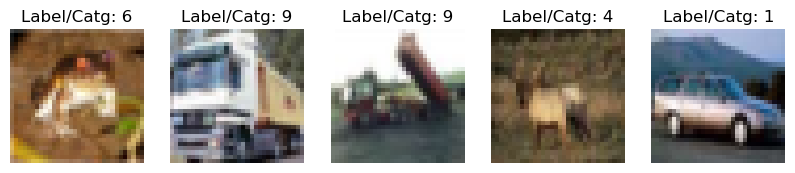

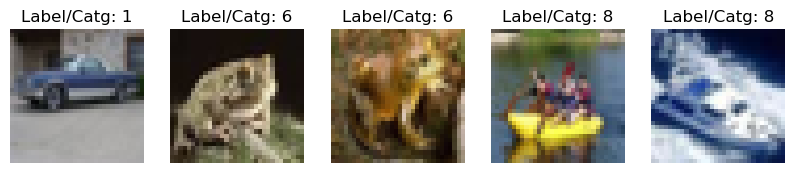

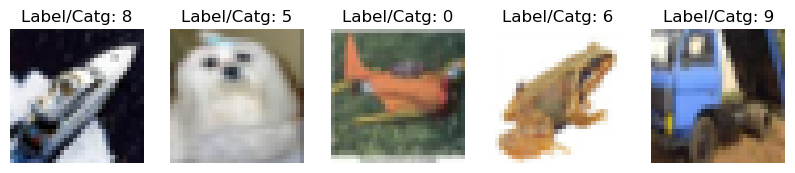

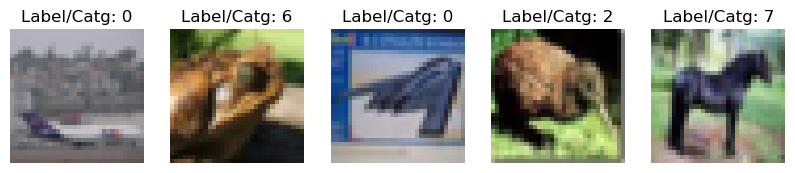

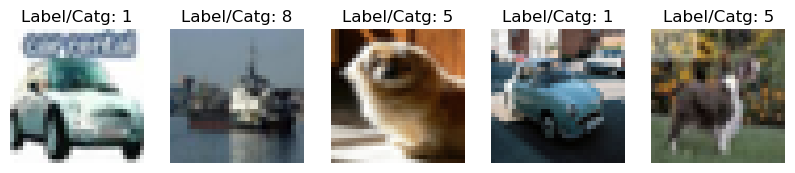

In [3]:
import numpy as np
import matplotlib.pyplot as plt
test = False
#function to load and serialize the CIFAR-10 dataset files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# dataset checking and preparation
batch_list = []

#import all 5 data batches of image
for i in range (1,6):  
    db = unpickle(f'data_batch_{i}')
    batch_list.append(db)

#checking
for index, batch  in enumerate(batch_list):
    print(f"Data Batch {index + 1} length: ", len(batch))
    print(f"Data Batch {index + 1} keys: ", batch.keys())
    print(f"Data Batch {index + 1} data file type:", batch[b'data'].dtype)
    print(f"Data Batch {index + 1} data file shape:", batch[b'data'].shape)
    print()
    
batch[b'data']

#display image 
def plot_images(images, labels, num_images):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2)) #create subplot with 1 row and 5 column
    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.set_title(f"Label/Catg: {labels[i]}")
        ax.axis('off') 
    plt.show()

for batch in batch_list:
    #reshape data from flatten array 10000x3072 to 10000x32x32x3 RGB images
    images_reshaped = batch[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1) #transpose into (10000x32x32x3) position
    labels = batch[b'labels']
    plot_images(images_reshaped, labels, num_images=5) #show 5 image

### Model Development

#### Support Vector Machine (SVM)

#### Original input features

In [14]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Data splitting
# Combining all batches for training and validation
all_data = np.vstack([batch[b'data'] for batch in batch_list])
all_labels = np.hstack([batch[b'labels'] for batch in batch_list])

# Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(all_data, all_labels, test_size=0.30, random_state=25)

# Flattening y_train and y_val are 1D arrays
y_train = np.array(y_train).flatten()
y_val = np.array(y_val).flatten()

# Shape verification
print(f"x_train_batch shape: {x_train.shape}")
print(f"y_train_batch shape: {y_train.shape}")
print(f"x_val_batch shape: {x_val.shape}")
print(f"y_val_batch shape: {y_val.shape}")

# Pipeline setup
# setting up the pipeline with StandardScaler and SVC
pipelineSVM = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC())
])
#using best parameters from earlier grid searches to speed up compute times
if not test:
    pipelineSVM = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', C=10, gamma='scale'))
    ])
    pipelineSVM.fit(x_train, y_train)
    yPred = pipelineSVM.predict(x_val)
    print("\nClassification Report:\n", classification_report(y_val, yPred))
else:
    # Cross-validation setup (StratifiedKFold)
    skfSVM = StratifiedKFold(n_splits=3, shuffle=True, random_state=25)

    # Parameter grid
    # defining a simplified parameter grid for GridSearch
    #to aid speed, we narrowed down params when possible just to hasten execution
    params = {
        'clf__kernel': [ 'rbf'],
        'clf__C': [ 1, 10],
        'clf__gamma': ['scale']
    }
    
    # Grid serach(GridSearchCV)
    grid = GridSearchCV(
        pipelineSVM, 
        params, 
        cv=skfSVM, 
        refit=True, 
        verbose=3, 
        n_jobs=5,  # Setting n_jobs=1 to reduce CPU load
        error_score='raise'
    )

    try:
        print("Starting grid search...")
        grid.fit(x_train, y_train)
        print("Grid search completed successfully.")
    
        # Predicting on the validation set
        gridPred = grid.predict(x_val)
    
        # Printing results
        print("Best Parameters: ", grid.best_params_)
        print("Best Estimator: ", grid.best_estimator_)
        print("\nClassification Report:\n", classification_report(y_val, gridPred))
    
    except Exception as e:
        print(f"An error occurred: {e}")

#Backup: [run the first batch of data, to decrease the computation load]
#splitting the first batch of data into training and validation sets
#x_train_batch_1, x_val_batch_1, y_train_batch_1, y_val_batch_1 = train_test_split(
#    batch_list[0][b'data'], 
#    batch_list[0][b'labels'], 
#    test_size=0.30, 
#    random_state=25
#)

x_train_batch shape: (35000, 3072)
y_train_batch shape: (35000,)
x_val_batch shape: (15000, 3072)
y_val_batch shape: (15000,)

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.61      0.59      1437
           1       0.63      0.69      0.66      1425
           2       0.42      0.43      0.43      1521
           3       0.39      0.39      0.39      1509
           4       0.46      0.47      0.46      1503
           5       0.47      0.43      0.45      1550
           6       0.59      0.58      0.58      1475
           7       0.64      0.58      0.61      1528
           8       0.70      0.68      0.69      1532
           9       0.61      0.62      0.62      1520

    accuracy                           0.55     15000
   macro avg       0.55      0.55      0.55     15000
weighted avg       0.55      0.55      0.55     15000



#### Feature Extraction 1: (PCA)

In [20]:
from sklearn.decomposition import PCA

# Reducing 50,000 image features down to 100 components using PCA 
n_components = 100 
pca = PCA(n_components=n_components, random_state=42)

# Training on the input features
x_train_pca = pca.fit_transform(x_train)
x_val_pca = pca.transform(x_val)

# Checking variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Cumulative explained variance by 100 components: {explained_variance:.2%}")
print(f"x_train_pca shape: {x_train_pca.shape}")
print(f"x_val_pca shape: {x_val_pca.shape}")

# Grid Search or if not testing, predict with best params
if not test:
    grid = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC(kernel='rbf', C=10, gamma='scale'))
        ])

grid.fit(x_train_pca, y_train)
gridPred = grid.predict(x_val_pca)

Cumulative explained variance by 100 components: 90.12%
x_train_pca shape: (35000, 100)
x_val_pca shape: (15000, 100)


NameError: name 'accuracy_score' is not defined

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Evaluation

accuracy = accuracy_score(y_val, gridPred)
cm = confusion_matrix(y_val, gridPred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", cm)

Accuracy: 0.5420666666666667
Confusion Matrix:
 [[885  66  71  38  32  27  20  42 166  90]
 [ 53 974  15  26  10  21  24  25  55 222]
 [121  53 624 136 220 130 107  63  29  38]
 [ 38  41 146 583  82 306 135  80  31  67]
 [ 69  23 222  94 717  88 106 132  23  29]
 [ 27  33 141 329 106 666  69 123   9  47]
 [ 21  29 126 138 147  87 858  28  11  30]
 [ 40  29  85  99 137 131  25 892  14  76]
 [186 109  32  35  28  27   7  13 982 113]
 [ 85 242  21  46  15  33  20  38  70 950]]


#### Feature extraction 2: HOG

In [33]:
from skimage.feature import hog

# Combining all batches for training and validation
all_data = np.vstack([batch[b'data'] for batch in batch_list])
all_labels = np.hstack([batch[b'labels'] for batch in batch_list])

# Splitting the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(all_data, all_labels, test_size=0.30, random_state=25)

# Ensure y_train and y_val lables are 1D arrays
y_train = np.array(y_train).flatten()
y_val = np.array(y_val).flatten()

# Reshape the images before passing them to HOG
# HOG requires input image in 2D / 3D format
x_train_images = x_train.reshape(-1, 32, 32, 3)
x_val_images = x_val.reshape(-1, 32, 32, 3)

# Example of HOG feature extraction
def extract_hog_features(images):
    hog_features = []
    for image in images:
        feature = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), channel_axis=-1)
        hog_features.append(feature)
    return np.array(hog_features)

# Extract HOG features
x_train_hog = extract_hog_features(x_train_images)
x_val_hog = extract_hog_features(x_val_images)

print(f"x_train_hog shape: {x_train_hog.shape}")
print(f"x_val_hog shape: {x_val_hog.shape}")

# Standardlize pixel values
scaler = StandardScaler()
x_train_hog = scaler.fit_transform(x_train_hog)
x_val_hog = scaler.transform(x_val_hog)

# Setting up the pipeline with SVC
pipelineSVM = Pipeline([
    ('clf', SVC())
])

# Setting up StratifiedKFold
skfSVM = StratifiedKFold(n_splits=3, shuffle=True, random_state=25)

# Defining an extended parameter grid for GridSearch or predicting with best params
if not test:
    hogPipeline = Pipeline([
        ('clf', SVC(kernel='rbf', C=1, gamma='scale'))
    ])
    hogPipeline.fit(x_train_hog, y_train)
    hogPred = hogPipeline.predict(x_val_hog)
    print("\nClassification Report:\n", classification_report(y_val, hogPred))
    
    # Calculate and print the accuracy and confusion matrix
    accuracy_hog = accuracy_score(y_val, hogPred)
    cm_hog = confusion_matrix(y_val, hogPred)
    
    print(f"Accuracy: {accuracy_hog}")
    print("Confusion Matrix:\n", cm_hog)
else:
    params = {
        'clf__kernel': ['rbf'],
        'clf__C': [ 1, 10],
        'clf__gamma': ['scale']
    }

    # Setting up and running GridSearchCV
    grid = GridSearchCV(
        pipelineSVM, 
        params, 
        cv=skfSVM, 
        refit=True, 
        verbose=3, 
        n_jobs=5,  # Setting n_jobs=1 to reduce CPU load
        error_score='raise'
    )

    try:
        print("Starting grid search with HOG features...")
        grid.fit(x_train_hog, y_train)
        print("Grid search completed successfully.")
    
        # Predicting on the validation set
        gridPred_hog = grid.predict(x_val_hog)
    
        # Printing results
        print("Best Parameters: ", grid.best_params_)
        print("Best Estimator: ", grid.best_estimator_)
        print("\nClassification Report:\n", classification_report(y_val, gridPred_hog))
    
        # Calculate and print the accuracy and confusion matrix
        accuracy_hog = accuracy_score(y_val, gridPred_hog)
        cm_hog = confusion_matrix(y_val, gridPred_hog)
    
        print(f"Accuracy: {accuracy_hog}")
        print("Confusion Matrix:\n", cm_hog)
    
    except Exception as e:
        print(f"An error occurred: {e}")


x_train_hog shape: (35000, 324)
x_val_hog shape: (15000, 324)

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.47      0.47      1437
           1       0.39      0.47      0.43      1425
           2       0.39      0.32      0.35      1521
           3       0.31      0.30      0.31      1509
           4       0.34      0.32      0.33      1503
           5       0.35      0.34      0.35      1550
           6       0.37      0.48      0.42      1475
           7       0.44      0.39      0.41      1528
           8       0.47      0.50      0.48      1532
           9       0.38      0.37      0.38      1520

    accuracy                           0.39     15000
   macro avg       0.39      0.39      0.39     15000
weighted avg       0.39      0.39      0.39     15000

Accuracy: 0.39286666666666664
Confusion Matrix:
 [[670 126  87  59  55  41  39  63 245  52]
 [ 85 671  25  45  55  24 113  72 136 199]
 [125  49 484 162 1

### Actual test_batch prediction

In [37]:
#jun- use the SVM-HOG model to predict on the test_batch
from sklearn.metrics import classification_report, accuracy_score

# Load the test batch
test_batch = unpickle('test_batch')

# Prepare the test data (reshape both input feature and label)
x_final_test = test_batch[b'data'].reshape(-1, 32, 32, 3)
y_final_test = np.array(test_batch[b'labels']).flatten()

# Extract HOG features from the test data
print("Extracting HOG features for test data...")
test_batch_hog = extract_hog_features(x_final_test)

x_test_scaled = scaler.transform(test_batch_hog)

# Setup pipeline with standarization and svm
pipelineFinal = Pipeline([
    ('clf', SVC(C=1, gamma='scale', kernel='rbf')) #c=1 is the best parameter given from HOG training
])

# Fit
pipelineFinal.fit(x_train_hog, y_train)
print("Predicting on test set...")
y_Pred = pipelineFinal.predict(x_test_scaled)


Extracting HOG features for test data...
Predicting on test set...


Accuracy Score:  0.3937
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50      1000
           1       0.41      0.46      0.43      1000
           2       0.39      0.31      0.35      1000
           3       0.30      0.30      0.30      1000
           4       0.35      0.32      0.34      1000
           5       0.33      0.35      0.34      1000
           6       0.38      0.48      0.43      1000
           7       0.41      0.37      0.39      1000
           8       0.47      0.50      0.49      1000
           9       0.37      0.36      0.36      1000

    accuracy                           0.39     10000
   macro avg       0.39      0.39      0.39     10000
weighted avg       0.39      0.39      0.39     10000

Confusion Matrix:
 [[496  60  69  25  40  40  20  38 161  51]
 [ 55 458   9  27  46  18  79  59 108 141]
 [ 90  31 313 110  87 131 123  53  34  28]
 [ 62  49  76 296  56 173 138  53  25  72]
 [

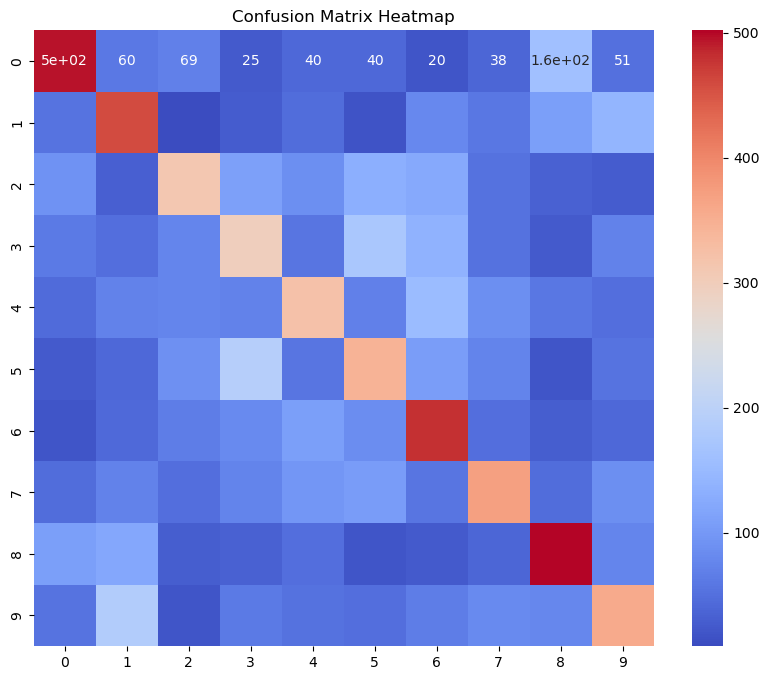

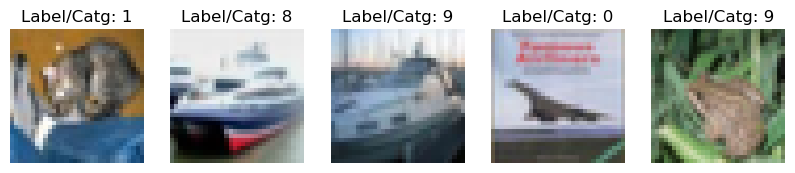

In [39]:
# Evaluataion
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print('Accuracy Score: ', accuracy_score(y_final_test, y_Pred))
print("Classification Report:\n", classification_report(y_final_test, y_Pred))

cm = confusion_matrix(y_final_test, y_Pred)
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='coolwarm')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Visualisatino
images_reshaped = test_batch[b'data'].reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1) 
labels = y_Pred
plot_images(images_reshaped, labels, num_images=5) #show 5 image